In [1]:
import torch
from pytorch_lightning import LightningModule
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [2]:
try:
    from torchts.nn.models.ode import ODESolver
    from torchts.nn.models.hybridode import HybridODENet
except ModuleNotFoundError:
    import sys
    sys.path.append("../../..")
    from torchts.nn.models.ode import ODESolver
    from torchts.nn.models.hybridode import HybridODENet

In [3]:
# Duffing equation: Second order ODE system
dt = 0.01

def x_prime(prev_val, coeffs, dnns):
    return prev_val["x_"]

def x_prime_prime(prev_val, coeffs, dnns):
    return 0.8*torch.cos(0.5*prev_val["t"]) - coeffs["d"]*prev_val["x_"] - coeffs["a"]*prev_val["x"] - coeffs["b"]*prev_val["x"]*prev_val["x"]*prev_val["x"]

def t_prime(prev_val, coeffs, dnns):
    return 1

ode = {"x": x_prime, "x_": x_prime_prime, "t": t_prime}

# Initial conditions [0,0,0]
ode_init = {"x": 0, "x_": 0, "t": 0}

# Constants (Parameters)
ode_coeffs = {"a": 0.1, "b": 0.5, "d": 0.2}

# 4th Order Runge-Kutta - Data Generation for nt = 1000

In [4]:
ode_solver = HybridODENet(
    ode=ode,
    dnns={},
    init_vars=ode_init,
    init_coeffs=ode_coeffs,
    dt=dt,
    optimizer=None
)

result = ode_solver(1000)

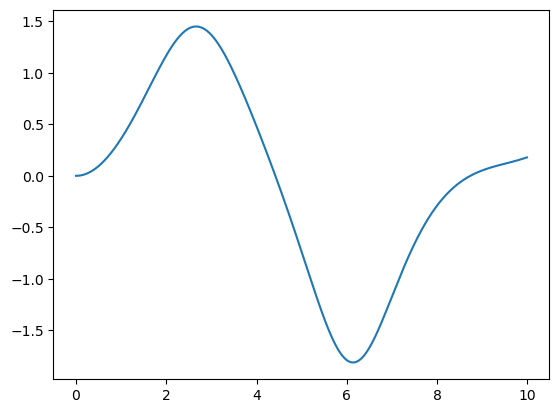

In [5]:
result_np = result.detach().numpy() # Convert to numpy array

# 2D plot of X and Z
plt.plot(result_np[:,2], result_np[:,0])

plt.show()

# Euler's method for training

In [6]:
def x_prime_prime_train(prev_val, coeffs, dnns):
    return dnns["f"](torch.Tensor([prev_val["t"]]))[0] - coeffs["d"]*prev_val["x_"] - coeffs["a"]*prev_val["x"] - coeffs["b"]*prev_val["x"]*prev_val["x"]*prev_val["x"]


In [7]:
dnns = {"f": nn.Sequential(
            nn.Linear(1,10),
            nn.ReLU(),
            nn.Linear(10,1),
            nn.Tanh()
        )}

In [14]:
ode_train_coeffs = {"a": 0., "b": 0., "d": 0.}
ode_train = {"x": x_prime, "x_": x_prime_prime_train, "t": t_prime}

ode_solver_train = HybridODENet(
    ode=ode_train,
    dnns=dnns,
    init_vars=ode_init,
    init_coeffs=ode_train_coeffs,
    dt=dt,
    solver="euler",
    optimizer=torch.optim.Adam,
    optimizer_args={"lr": 0.5},
    scheduler=torch.optim.lr_scheduler.MultiStepLR,
    scheduler_args={"milestones": [5],"gamma": 0.2}
)

In [15]:
ode_solver_train.register_parameter("f0", dnns["f"][0].weight)
ode_solver_train.register_parameter("f2", dnns["f"][2].weight)

In [16]:
for param in ode_solver_train.parameters():
    print(param)

Parameter containing:
tensor(0., requires_grad=True)
Parameter containing:
tensor(0., requires_grad=True)
Parameter containing:
tensor(0., requires_grad=True)
Parameter containing:
tensor([[ 0.2142],
        [-0.8496],
        [ 0.5126],
        [-0.8355],
        [-0.4257],
        [-0.9374],
        [ 0.4995],
        [-0.3751],
        [-0.7042],
        [-0.2644]], requires_grad=True)
Parameter containing:
tensor([[ 0.3312,  0.3463,  0.0904,  0.1946, -0.0459, -0.0237,  0.1171,  0.2378,
         -0.0938, -0.1383]], requires_grad=True)


In [17]:
ode_solver_train.fit(
    result,result,
    max_epochs=1,
    batch_size=result.shape[0]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type | Params
------------------------------
------------------------------
23        Trainable params
0         Non-trainable params
23        Total params
0.000     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

In [ ]:
result_train = ode_solver_train(1000)

result_np = result.detach().numpy() # Convert to numpy array

# 2D plot of X and Z
plt.plot(result_np[:,2], result_np[:,0])

plt.show()

# Mean Squared Error Loss

In [ ]:
loss = torch.nn.MSELoss()
loss(result_train,result)